# Introduction to text analysis VIII #

*Revision 2019*

## topic detection ##

Topic detection is a way to extract relevant information from texts. The topic is a set of words (from the text) having particular relevance in terms of probability. They apper to be words that characterize the topics (one or more) discussed in the documents.

**definitions:**

* Document: A single text, paragraph or even tweet to be classified
* Word/Term: a single component of a document
* Topic: a set of words describing a group (cluster) of documents

**each document usually is as a mixture of several topics**

### mixture of topics ###

A model such as LDA will produce an classification such as the following:

* Sentences 1 and 2: 100% Topic A
* Sentences 3 and 4: 100% Topic B
* Sentence 5: 60% Topic A, 40% Topic B

Topic A: 30% broccoli, 15% bananas, 10% breakfast, 10% munching, … (at which point, you could interpret topic A to be about food)

Topic B: 20% chinchillas, 20% kittens, 20% cute, 15% hamster, … (at which point, you could interpret topic B to be about cute animals)

### methodologies ###

* latent dirichlet allocation (lda) 
* Non negative matrix factorization
* Clustering 

**latent dirichlet allocation (lda)** 

It's a complex mathematical model (based on Bayesian statistics and Dirichlet and Multinomial distributions) to establish the words in a set of documents that are the most representative. The starting point is definining a 

* fixed number of topics K
* to each topic k we associate a probability p = p(k|w) i.e. the probability of seeing the topic k given the set of words w in the document d
* to each topic k we associate a probability s = s(k,d) i.e. the probability of a k topic belonging to the document d. The distribution s represents the mixture of topics related to d
* A word in the document is picked by randomly extracting from a topic and from a document according to s and p distributions
* An optimization is performed fitting the s,p distributions to the actual distribution of words in the documents.

**Non negative matrix factorization**

![title](./NMF.png)

* **V**  is the matrix representing all documents
* **H** is the matrix representing documents given the topics
* **W** is the matrix representing the topics


the factorization is made using objective functions such as *Frobenius Norm *

### Main features ###

**LDA**

* Slow method
* Quite accurate for large corpora where each document is a mixture of topics
* Most adopted 

**NMF**

* Fast method
* Accurate with small corpora (i.e. tweets) or tweets with no mixture of topics
* not commonly adopted


## hands on ##

In [7]:
import string
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import re

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [9]:
from sklearn.datasets import fetch_20newsgroups

**get the corpus**

20 newsgroup

In [10]:
newsgroups = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))
docs_raw = newsgroups.data
print(len(docs_raw))

11314


names for classification or for topic detection

In [12]:
newsgroups.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

stopwords

In [13]:
stops_it = stopwords.words('italian')
stops_en = stopwords.words('english')

translator = str.maketrans(' ', ' ', string.punctuation) ## remove the punctuation

In [14]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

functions for text processing

In [15]:
def minimumSize(tokens,llen = 2):
    ## remove words smaller than llen chars
    tks = []
    for t in tokens:
        if(len(t) > llen):
            tks.append(t)
    return tks

def removeStops(tokens,stops = stops_it):
    # remove stop words
    remains = []
    for t in tokens:
        if(t not in stops):
            remains.append(t)
    return remains

def processText(text):
    ## tokenizer with stop words removal and minimum size 
    tks = word_tokenize(text)
    tks = [t.translate(translator) for t in tks] ## remove the punctuation
    tks = minimumSize(tks)
    tks = removeStops(tks,stops_en)
    return tks

### TFIDF vectorizer ###

It transforms each word in the D documents in a sparse matrix representing a normalized frequency of each word in each document. 

In [16]:
n_features = 3000 
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,tokenizer=processText)

**n_features** it's the number of individual ters from the corpus to use (notice that rarely a language by humans uses more than few thousands of distinct words ). Having a large dataset it is safe to use large number for n_features, for short corpus n_features must be not a large number

**max_df** is the probability at which the more probable words must be removed (removes the most common words)

**min_df** removes the words appearing less than 2 times in the dataset.


In [18]:
%%time
corpusT = docs_raw[0:500] ## let's use the first 500 documents

corpusT = docs_raw
tfidf = tfidf_vectorizer.fit_transform(corpusT)

CPU times: user 18.2 s, sys: 0 ns, total: 18.2 s
Wall time: 18.2 s


In [19]:
tfidf

<11314x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 464986 stored elements in Compressed Sparse Row format>

**Visualize the matrix of tfidf**

In [20]:
G = tfidf.todense()

In [21]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


just the first 100x100 points

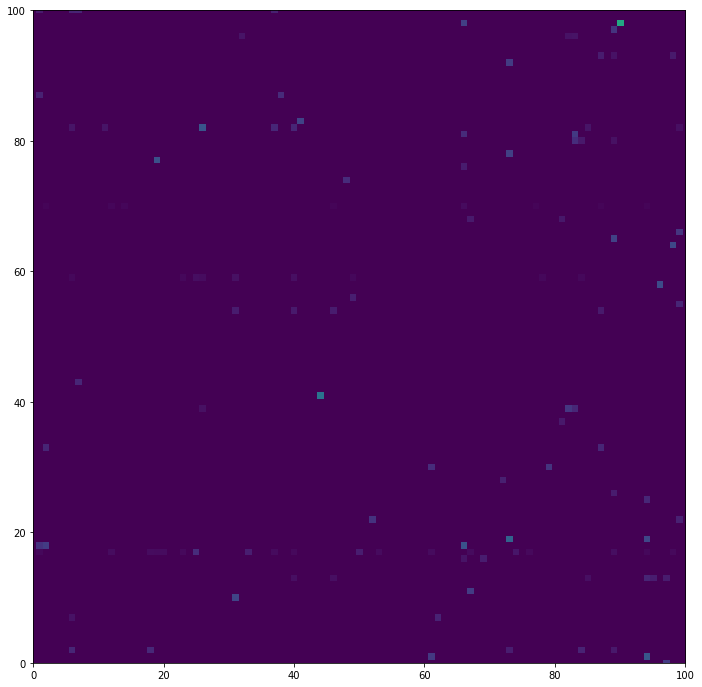

In [22]:
plt.figure(figsize = (12,12))
plt.xlim(0,100)
plt.ylim(0,100)
plt.imshow(G)

**associate names (words) to each feature**

In [23]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [24]:
len(tfidf_feature_names)

3000

**LDA**

latent dirichlet analysis 

In [27]:
n_topics = 20
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, 
                                learning_method = 'batch')


* **n_components** is somehow arbitrary. 
* **max_iter** stops the iteration after maximum 10
* **learning method** is usually online but can be also batch (slower) when all data are processed at time

In [28]:
lda.fit(tfidf) ## fit the model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [29]:
def mostImportantWordsPerTopic(feature_names,topic,n_top_words):
    mwords = []
    sort_topic = topic.argsort()
    mw = sort_topic[:-n_top_words - 1:-1] ## reversed list    
    for idx in mw:
        mwords.append(feature_names[idx])
    return mwords
        

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        
        most_important_words = mostImportantWordsPerTopic(feature_names,topic,n_top_words)

        message = "Topic #%d: " % topic_idx
        message += " ".join(most_important_words)
        print(message)
    print()

**Printing the topics**

In [30]:
n_top_words = 10
print_top_words(lda, tfidf_feature_names, n_top_words)

Topic #0: key encryption chip clipper keys escrow algorithm nsa des secure
Topic #1: flyers mask keith test cal bos pit van min bmw
Topic #2: cancer pope sabbath faq quote authority newsgroups miller distribution stephen
Topic #3: max try soul b8f era 000 already 145 fourth a86
Topic #4: thanks email please anyone address info looking information advance know
Topic #5: bob kent cheers sea stay writes away say brake could
Topic #6: drive card windows use thanks email please system one anyone
Topic #7: jon film virtual 4th sharks shipping reality camera universe favorite
Topic #8: god jesus bible christ church christians christian faith sin heaven
Topic #9: israel israeli jews armenian turkish armenians arab arabs jewish turkey
Topic #10: files file thanks ftp program windows directory anyone format know
Topic #11: team game games players year season hockey play teams win
Topic #12: gordon surrender banks geb intellect shameful skepticism chastity n3jxp cadredslpittedu
Topic #13: window 

**NMF**

In [31]:
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

**parameters**

NMF is basically free of parameters :).
    
* **alpha** : regolarization parameter (used to smooth the frequencies and to improve the fit)
* **l1_ratio** : regolarization parameter (used to smooth the frequencies and to improve the fit)

In [32]:
n_top_words = 10
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: people think get time good well could much even see
Topic #1: sale new offer price condition shipping asking excellent sell best
Topic #2: god jesus bible christ faith believe christians christian lord church
Topic #3: thanks please email advance address looking send info information post
Topic #4: drive scsi drives disk hard ide floppy controller mac boot
Topic #5: geb n3jxp chastity cadredslpittedu shameful intellect skepticism surrender gordon banks
Topic #6: file files directory program ftp format image available gif site
Topic #7: would appreciated appreciate greatly could help someone sure nice wondering
Topic #8: game team games year players season hockey play last win
Topic #9: key chip encryption clipper keys escrow government algorithm system security
Topic #10: armenian armenians turkish armenia turkey genocide turks people government argic
Topic #11: card video monitor cards vga drivers bus driver color ram
Topic #12: one two another thing word claim buy seen side

### Bonus visualization ###

a library with an interactive widget to explore topics

In [33]:
import pyLDAvis
import pyLDAvis.sklearn
#pyLDAvis.enable_notebook()

In [34]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [35]:
import warnings
warnings.filterwarnings('ignore')

**default visualization of topics and frequency in a multidimensional space**

In [36]:
ld = pyLDAvis.sklearn.prepare(lda, tfidf, tfidf_vectorizer)

**another decomposition method**

In [38]:
pyLDAvis.display(ld)

### Exercises: ###

* Explore the 20newsgroup dataset and try to improve the fit according to a better selection of number of feature (i.e. change how the tfidf is built)
    
